In [1]:
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.tseries.offsets import DateOffset
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [2]:
pd.read_excel("INDPRO.xls")

dis = pd.read_excel('INDPRO.xls')
dis.head(100)

#monthly industrial production level and interest rate data for U.S
#data from FRED


,Date,INDPRO,INTEREST
0,2010-01-01,91.6642,0.50
1,2010-02-01,91.9940,0.75
2,2010-03-01,92.5993,0.75
3,2010-04-01,92.9436,0.75
4,2010-05-01,94.2997,0.75
...,...,...,...
95,2017-12-01,106.5360,2.00
96,2018-01-01,106.2655,2.00
97,2018-02-01,106.6419,2.00
98,2018-03-01,107.2519,2.25


<AxesSubplot:xlabel='Date'>

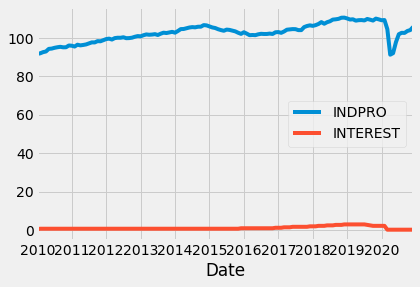

In [3]:
df2=dis.set_index('Date')
df2.index
df2.plot()

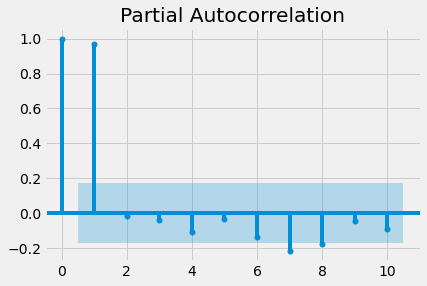

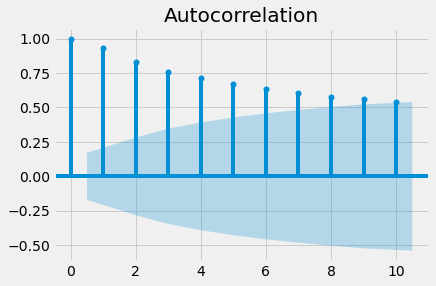

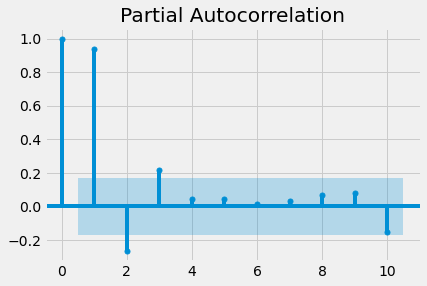

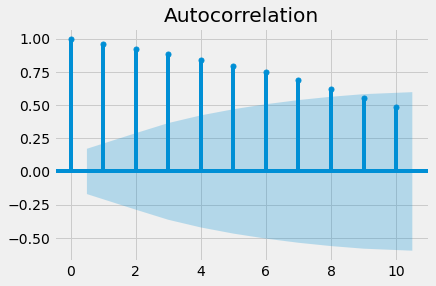

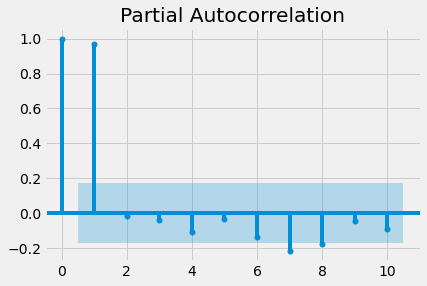

In [4]:
plot_acf(df2['INDPRO'],lags=10)
plot_pacf(df2['INDPRO'],lags=10)
plot_acf(df2['INTEREST'],lags=10)
plot_pacf(df2['INTEREST'],lags=10)

<AxesSubplot:xlabel='Date'>

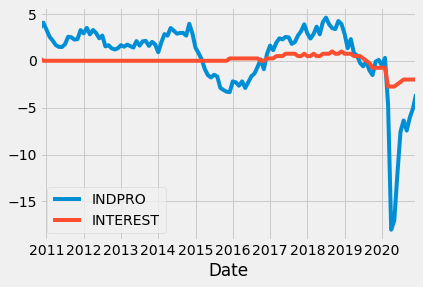

In [5]:
dif_df2=df2.diff(10).dropna()
dif_df2.plot()

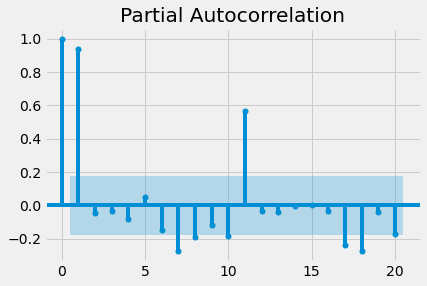

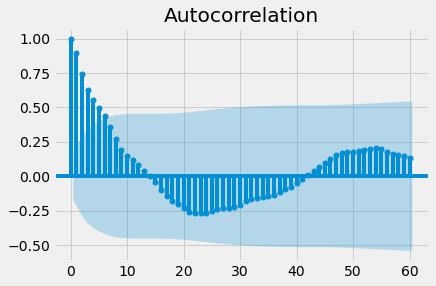

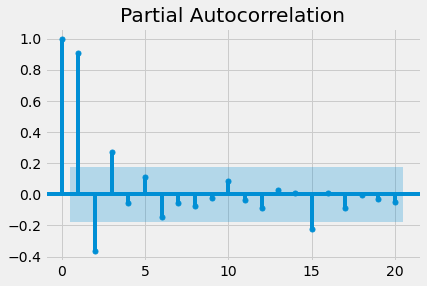

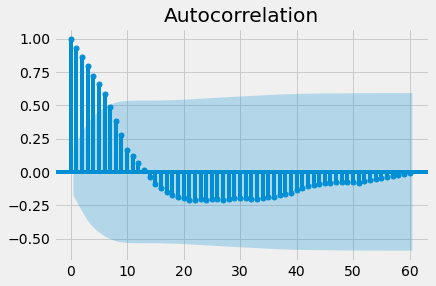

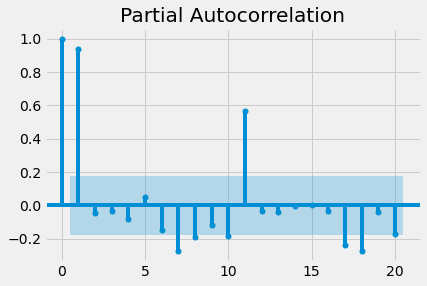

In [6]:
plot_acf(dif_df2['INDPRO'],lags=60)
plot_pacf(dif_df2['INDPRO'],lags=20)
plot_acf(dif_df2['INTEREST'],lags=60)
plot_pacf(dif_df2['INTEREST'],lags=20)

In [7]:
Xtrain,Xtest,Ytrain,Ytest=df2['INDPRO'].iloc[:60],df2['INDPRO'].iloc[60:],df2['INTEREST'].iloc[:60],df2['INTEREST'].iloc[60:]

                                 SARIMAX Results                                 
Dep. Variable:                    INDPRO   No. Observations:                   60
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood                 -31.352
Date:                   Sat, 13 Feb 2021   AIC                             72.705
Time:                           15:39:51   BIC                             83.092
Sample:                       01-01-2010   HQIC                            76.760
                            - 12-01-2014                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INTEREST       0.7203      5.325      0.135      0.892      -9.716      11.156
ar.L1          0.9999      0.005    214.774      0.000       0.991       1.009
ma.L1         -1.0455      0

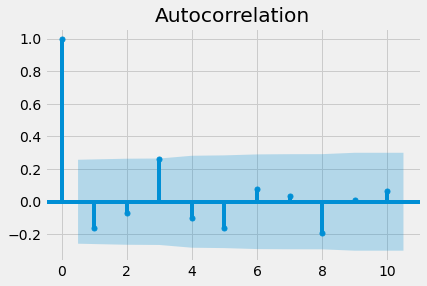

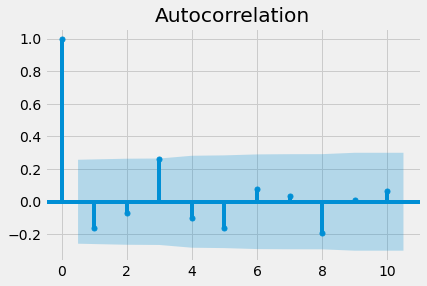

In [8]:
ar = 1 
ma = (1,0,0,1)
model2=sm.tsa.statespace.SARIMAX(endog=Xtrain,exog=Ytrain,trend='n',order=(ar,1,ma),enforce_stationarity=True, enforce_invertibility=True)
results2=model2.fit(disp=False)
print(results2.summary())
residuals2=results2.resid
residuals2=residuals2.iloc[1:-1]


plot_acf(residuals2,lags=10)


In [17]:
###Pseudo prediction
pred2=results2.get_prediction(exog=Ytest, dynamic=True)
pred_pseudo2=pred2.predicted_mean
mape1=100*(abs(Xtest-pred_pseudo2)/Xtest).mean()
results2
mape1

nan

<AxesSubplot:>

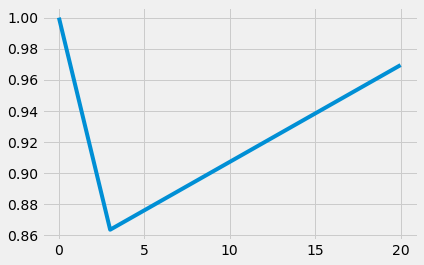

In [18]:
irf = results2.impulse_responses(20)
irf.plot()


<AxesSubplot:xlabel='Date'>

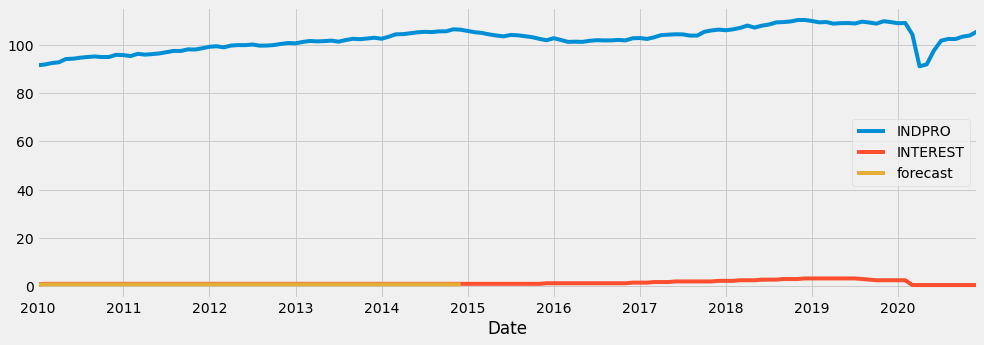

In [22]:
#Sample prediction
df2["forecast"] = results2.predict(exog=Ytest, dynamic=True)
df2.plot(figsize=(15,5))

                                     SARIMAX Results                                      
Dep. Variable:                           INTEREST   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 10)   Log Likelihood                  94.665
Date:                            Sat, 13 Feb 2021   AIC                           -181.330
Time:                                    15:46:11   BIC                           -173.763
Sample:                                01-01-2010   HQIC                          -178.459
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
INDPRO        -0.0113      0.027     -0.412      0.681      -0.065       0.043
ar.L1          0.4744      0.080   

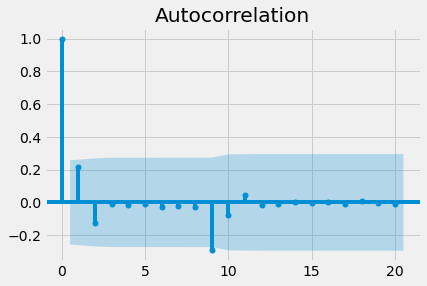

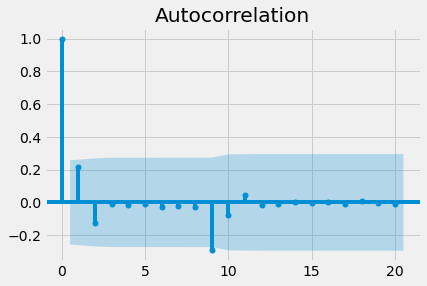

In [23]:
model3=sm.tsa.statespace.SARIMAX(exog=Xtrain,endog=Ytrain,trend='n',order=(1,1,0),seasonal_order=(1,1,0,10))
results3=model3.fit(disp=False)
print(results3.summary())
residuals3=results3.resid
residuals3=residuals3.iloc[1:-1]
plot_acf(residuals3,lags=20)



In [25]:
#pseudo prediction
pred3=results3.get_prediction(exog=Xtest, dynamic=True)
pred_pseudo3=pred3.predicted_mean
mape3=100*(abs(Xtest-pred_pseudo3)/Xtest).mean()
print(mape3)

nan


<AxesSubplot:>

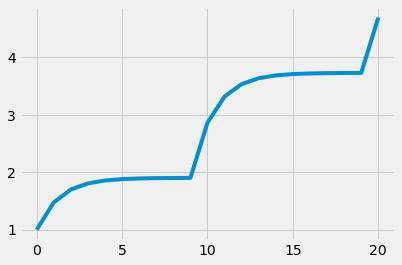

In [26]:
irf = results3.impulse_responses(20)
irf.plot()

<AxesSubplot:xlabel='Date'>

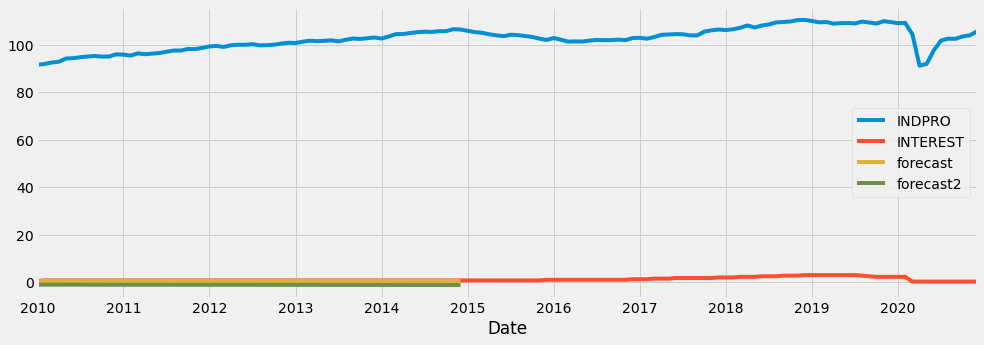

In [28]:
#forecast monthly

df2["forecast2"] = results3.predict(exog=Xtest, dynamic=True)
df2.plot(figsize=(15,5))


In [29]:
#out of sample

future_dates=[df2.index[-1]+ DateOffset(months=x)for x in range(0,41)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df2.columns)
future_df= pd.concat([df2,future_datest_df])

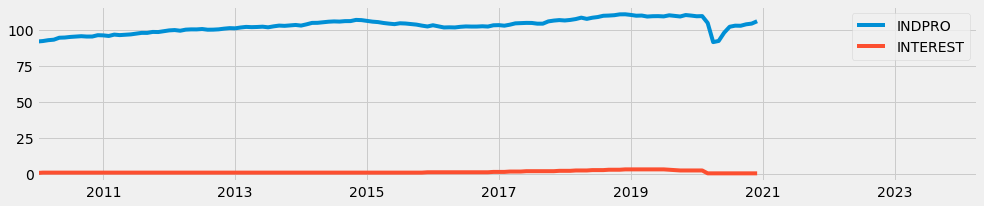

In [32]:
future_df["forecast2"] = results3.predict(exog=Xtest, dynamic=True)
future_df[["INDPRO", "INTEREST" ]].plot(figsize=(15,3))


#Hodrick-Prescott

dis.index=pd.to_datetime(dis.index)
cycle, trend = sm.tsa.filters.hpfilter(df2.INDPRO, lamb=1600)
gdp_decomp = dis[['INDPRO']]
gdp_decomp["cycle"] = cycle
gdp_decomp["trend"] = trend
plt.plot(gdp_decomp[["INDPRO", "trend"]])